In [1]:
import time
import folium
import geopandas as gpd #A more flexible package to work with geospatial data in python 
from itertools import product
import json
import matplotlib.pyplot as plt
import networkx as nx # networkx package 
import numpy as np
from osgeo import ogr #GDAL package 
import osmnx as ox 
import pandas as pd #Base package for data analysis and manipulation 
from pyproj import CRS #package for your projection management 
import random
import rasterio as rio
from rasterio import mask
import rasterstats as rs
import requests
import shapely.geometry #python package for basic spatial operation 
import xml.dom.minidom


In [2]:
#set the city names
g_namen = ["Utrecht"]
#g_namen = ["Den_Haag"]

#download city geometries from file
project_gemeenten = gpd.read_file(r"data\boundaries\UrbanRunner_Areas.geojson") ## dit komt van de cbs gemeentegrenzen. Beschrijven bij data

#set additional geometry column of extent
project_gemeenten["extent"] = project_gemeenten.envelope.buffer(2000).envelope.to_crs("EPSG:4326")

#set index to gemeentenaam column
project_gemeenten.set_index('gemeentenaam', inplace=True)

#project to WGS84
project_gemeenten.to_crs("EPSG:4326", inplace=True)


In [3]:
# get network
for g in g_namen:
    globals()[f"{g}_nodes"] = gpd.read_file(f'data/graphs/with_costs/{g}_graph_costs.gpkg', driver = "GPKG", layer= 'nodes').set_index('osmid') 
    globals()[f"{g}_edges"] = gpd.read_file(f'data/graphs/with_costs/{g}_graph_costs.gpkg', driver = "GPKG", layer= 'edges').set_index(['u', 'v', 'key'])
    edges = globals()[f"{g}_edges"]
    edges['cost_greenspace'][(edges['landuse'].isnull()) & (edges['leisure'].isnull()) & (edges['natural'].isnull())] = 1
    #final cost column are added before analysis to gain more flexibility in changing the cost function
    edges['final_cost_persona1'] = ((0.6*edges['cost_UHI']) + (0.8*edges['cost_greenspace']) + (0.2*edges['cost_grade']) + (0.3*edges['cost_disruptions']) + (0.1*edges['cost_surface_prefpaved'])) * edges['length']
    edges['final_cost_persona2'] = ((0.3*edges['cost_waterpoints']) + (0.6*edges['cost_UHI']) + (0.8*edges['cost_greenspace']) + (0.3*edges['cost_disruptions']) + (0.1*edges['cost_surface_prefunpaved'])) * edges['length']
    globals()[f"{g}_edges"] = edges
    globals()[f"{g}_network_both"] = ox.graph_from_gdfs(globals()[f"{g}_nodes"],globals()[f"{g}_edges"])

TypeError: cannot unpack non-iterable int object

In [39]:
def get_random_XY_in_polygon(poly): ## manier om XY coordinaten te pakken binnen een polygon
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = shapely.geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            return p.coords[0][0], p.coords[0][1]

In [75]:
#getting random nodes
n_routes = 50
for g in g_namen:
    X_list = []
    Y_list = []    
    for i in range((n_routes*2)):
        x, y = get_random_XY_in_polygon(project_gemeenten.to_crs('epsg:28992').loc[g].geometry)
        X_list.append(x)
        Y_list.append(y)
    random_nodes = ox.nearest_nodes(globals()[f"{g}_network_both"], X_list, Y_list)
    source_nodes = random_nodes[0:n_routes]
    goal_nodes = random_nodes[n_routes:(n_routes*2)]

In [59]:
SameNodesCount = 0
for routenr in range(n_routes):
    #print(routenr)
    source = source_nodes[routenr]
    goal = goal_nodes[routenr]
    if source == goal:
        print('yeah, what is the chance to randomly select the same node?')
        SameNodesCount += 1
        continue
    # calculate routes ## !! Error handling needs to be included in case no route can be found!
    WillemijnRoute = nx.dijkstra_path(G=Utrecht_network_both, source=source, target=goal, weight='final_cost_persona1')
    RachidRoute = nx.dijkstra_path(G=Utrecht_network_both, source=source, target=goal, weight='final_cost_persona2')
    shortestroute = nx.dijkstra_path(G=Utrecht_network_both, source=source, target=goal, weight='length')
    
    # extract edge attributes of the routes
    #CRstats = pd.DataFrame(ox.utils_graph.get_route_edge_attributes(Gs, coolestroute)) 
    #SRstats = pd.DataFrame(ox.utils_graph.get_route_edge_attributes(Gs, shortestroute)) 
    WRstats = pd.DataFrame(ox.utils_graph.get_route_edge_attributes(Utrecht_network_both, WillemijnRoute))
    RRstats = pd.DataFrame(ox.utils_graph.get_route_edge_attributes(Utrecht_network_both, RachidRoute))
    SRstats = pd.DataFrame(ox.utils_graph.get_route_edge_attributes(Utrecht_network_both, shortestroute))
    if routenr == 0:
        RouteStats = pd.DataFrame([[source, goal, 
                            sum(WRstats.UHI_mean*WRstats.length)/sum(WRstats.length),                             
                            sum(RRstats.UHI_mean*RRstats.length)/sum(RRstats.length),                                   
                            sum(SRstats.UHI_mean*SRstats.length)/sum(SRstats.length),

                            sum(WRstats.length - (WRstats.cost_greenspace*WRstats.length))/sum(WRstats.length),
                            sum(RRstats.length - (RRstats.cost_greenspace*RRstats.length))/sum(RRstats.length),
                            sum(SRstats.length - (SRstats.cost_greenspace*SRstats.length))/sum(SRstats.length),

                            sum(WRstats.grade*WRstats.length)/sum(WRstats.length),
                            sum(SRstats.grade*SRstats.length)/sum(SRstats.length),

                            sum(WRstats.cost_surface_prefpaved*WRstats.length)/sum(WRstats.length),
                            sum(RRstats.cost_surface_prefunpaved*RRstats.length)/sum(RRstats.length),
                            sum(SRstats.cost_surface_prefpaved*SRstats.length)/sum(SRstats.length),
                            sum(SRstats.cost_surface_prefunpaved*SRstats.length)/sum(SRstats.length),

                            len(RRstats[RRstats.cost_waterpoints == 0]),
                            len(SRstats[SRstats.cost_waterpoints == 0]),

                            len(WRstats[WRstats.cost_disruptions == 1]),
                            len(RRstats[RRstats.cost_disruptions == 1]),
                            len(SRstats[SRstats.cost_disruptions == 1]),                      
                            
                            sum(WRstats.length), sum(RRstats.length), sum(SRstats.length)]],
                        columns=['source','target',
                            'WR_UHI','RR_UHI','SR_UHI',
                            'WR_greenspace', 'RR_greenspace', 'SR_greenspace', 
                            'WR_grade', 'SR_grade',
                            'WR_prefpaved','RR_prefunpaved','SR_prefpaved','SR_prefunpaved', 
                            'RR_water','SR_water', 
                            'WR_disruption','RR_disruption','SR_disruption', 
                            'WR_length', 'RR_length', 'SR_length'])
    else:
        RouteStats = RouteStats.append(pd.DataFrame([[source, goal, 
                            sum(WRstats.UHI_mean*WRstats.length)/sum(WRstats.length),                             
                            sum(RRstats.UHI_mean*RRstats.length)/sum(RRstats.length),                                   
                            sum(SRstats.UHI_mean*SRstats.length)/sum(SRstats.length),

                            sum(WRstats.length - (WRstats.cost_greenspace*WRstats.length))/sum(WRstats.length),
                            sum(RRstats.length - (RRstats.cost_greenspace*RRstats.length))/sum(RRstats.length),
                            sum(SRstats.length - (SRstats.cost_greenspace*SRstats.length))/sum(SRstats.length),

                            sum(WRstats.grade*WRstats.length)/sum(WRstats.length),
                            sum(SRstats.grade*SRstats.length)/sum(SRstats.length),

                            sum(WRstats.cost_surface_prefpaved*WRstats.length)/sum(WRstats.length),
                            sum(RRstats.cost_surface_prefunpaved*RRstats.length)/sum(RRstats.length),
                            sum(SRstats.cost_surface_prefpaved*SRstats.length)/sum(SRstats.length),
                            sum(SRstats.cost_surface_prefunpaved*SRstats.length)/sum(SRstats.length),

                            len(RRstats[RRstats.cost_waterpoints == 0]),
                            len(SRstats[SRstats.cost_waterpoints == 0]),

                            len(WRstats[WRstats.cost_disruptions == 1]),
                            len(RRstats[RRstats.cost_disruptions == 1]),
                            len(SRstats[SRstats.cost_disruptions == 1]),                      
                            
                            sum(WRstats.length), sum(RRstats.length), sum(SRstats.length)]],
                        columns=['source','target',
                            'WR_UHI','RR_UHI','SR_UHI',
                            'WR_greenspace', 'RR_greenspace', 'SR_greenspace', 
                            'WR_grade', 'SR_grade',
                            'WR_prefpaved','RR_prefunpaved','SR_prefpaved','SR_prefunpaved', 
                            'RR_water','SR_water', 
                            'WR_disruption','RR_disruption','SR_disruption', 
                            'WR_length', 'RR_length', 'SR_length']),
                  ignore_index=True)

C:\Users\danny\AppData\Local\Temp/ipykernel_5624/1804107176.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RouteStats = RouteStats.append(pd.DataFrame([[source, goal,
C:\Users\danny\AppData\Local\Temp/ipykernel_5624/1804107176.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RouteStats = RouteStats.append(pd.DataFrame([[source, goal,
C:\Users\danny\AppData\Local\Temp/ipykernel_5624/1804107176.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RouteStats = RouteStats.append(pd.DataFrame([[source, goal,
C:\Users\danny\AppData\Local\Temp/ipykernel_5624/1804107176.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RouteStats =

IndexError: list index out of range

<AxesSubplot:xlabel='RR_prefunpaved', ylabel='SR_prefunpaved'>

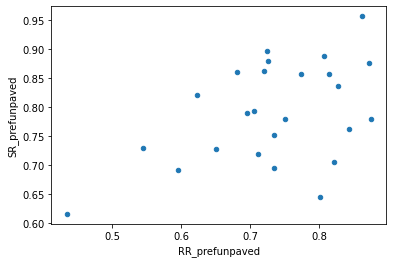

In [73]:
RouteStats.plot.scatter('RR_prefunpaved', 'SR_prefunpaved')

In [74]:
RouteStats

,source,target,WR_UHI,RR_UHI,SR_UHI,WR_greenspace,RR_greenspace,SR_greenspace,WR_grade,SR_grade,...,SR_prefpaved,SR_prefunpaved,RR_water,SR_water,WR_disruption,RR_disruption,SR_disruption,WR_length,RR_length,SR_length
0,4340451285,249344052,1.327172,1.327172,1.415887,0.713187,0.713187,0.468619,0.000088,0.000062,...,0.123192,0.876808,0,0,14,14,14,4900.007,4900.007,4307.639
1,1510275804,4188060461,0.717514,0.661611,0.727865,0.990011,0.941997,0.630231,-0.000186,-0.000138,...,0.384295,0.615705,13,0,4,4,4,3043.504,2734.061,2321.168
2,412312161,250150101,0.742610,0.738576,0.707866,0.738756,0.736920,0.468765,0.000201,0.000241,...,0.120624,0.879376,0,0,16,16,14,10373.842,10301.437,8379.916
3,9611706382,9243868054,0.619092,0.615849,0.739836,0.910644,0.905396,0.690955,0.000129,0.000163,...,0.111256,0.888744,0,0,8,8,16,5720.159,5622.733,5103.086
4,243193452,45301312,1.141137,1.142486,1.144157,0.769893,0.769871,0.648669,0.000119,0.000119,...,0.164072,0.835928,0,0,24,24,26,7819.123,7817.447,7492.089
5,4573306608,45233719,1.324283,1.366219,1.433461,0.946334,0.910794,0.496496,0.000085,0.000114,...,0.354479,0.645521,4,12,21,16,4,3646.966,3410.607,3207.574
6,9505100668,45138538,1.009485,1.147806,1.152168,0.733668,0.525097,0.459304,-0.000238,-0.000299,...,0.247174,0.752826,0,0,16,18,14,7091.057,5236.337,5226.693
7,318836073,244236273,1.091917,1.091917,1.147013,0.693806,0.693806,0.459312,0.000242,0.000306,...,0.219723,0.780277,0,0,14,14,7,6270.457,6270.457,5955.253
8,1814770415,1638158822,1.297711,1.304085,1.320867,0.800834,0.797765,0.596964,0.000488,0.000581,...,0.219704,0.780296,0,0,10,10,10,4311.521,4246.082,3945.929
9,1910104257,618808049,0.555732,1.227382,1.332901,0.937436,0.851799,0.550286,0.000010,-0.000005,...,0.210460,0.789540,20,5,12,20,38,21135.852,12991.823,11640.415


In [77]:
RouteStats.to_excel('data/routestats.xlsx')